In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Data science on responses to Automatique & Santé questionnaire
Action GDR MACS, Jérome Cieslak, Antoine Chaillet, JJ Aucouturier &copy; 2022

**Méthodologie:** 
- données récupérées de la déclaration d'intérêt, puis du questionnaire plus approfondi
- les questionnaires à choix multiples (ex. domaines cliniques = neurosciences, robotique chirurgicale, etc.) et à champ de réponse libre (ex. "principaux freins") sont re-encodés dans une nomenclature faite à la main, pour permettre de faire des histogrammes.
- les affiliations sont recodées en laboratoire, et géolocalisées par ville et département, pour affichage sur une carte
- les 2 questionnaires sont traités différemment, car listes choix multiples différentes, et les données sont fusionnées à la fin (note: le fichier de data manifestation_interet a été traité à la main par Antoine pour n'en garder que les entrées qui ne sont pas déjà dans le 2e questionnaire <mark> apparemment ce n'est pas le cas </mark>)

## Nettoyage des données

### Premier sondage (_Manifestation d'intérêt_) 

In [3]:
questions1_df = pd.read_csv('data/manifestation_interet.csv', encoding='latin1')

#### Rename columns 

In [4]:
questions1_df = questions1_df.rename(columns={'Horodateur':'date',
                                          'Quel est votre nom?':'last_name',
                                          'Quel est votre prénom?':'first_name', 
                                          'Si oui, dans quel domaine applicatif ? ':'clinical_domains',
                                          'Au travers de quels outils méthodologiques ?':'control_domains',
                                          'Si ces travaux ont déjà donné lieu à des publications, merci de nous en donner la liste:':'publication_list',
                                          'Sur le principe, seriez-vous intéressé par les actions suivantes (cette réponse ne constitue en rien un engagement de votre part!)':'interests',
                                          "Connaissez-vous des collègues (en France) dont les activités de recherche relèvent des outils de l'automatique utilisés pour la santé?":'recommendations',
                                          'Des suggestions ? Des remarques ?':'remarks'
                           })
questions1_df = questions1_df.drop(columns=['Avez-vous déjà travaillé sur des thématiques liant Automatique et Santé ou comptez-vous aborder de telles questions ?'])

In [5]:
# fix name formatting
questions1_df.first_name = questions1_df.first_name.str.capitalize()
questions1_df.last_name = questions1_df.last_name.str.capitalize()
questions1_df['respondent']=questions1_df['first_name']+" "+questions1_df['last_name']

#### Parse categories from multiple-choice questions

##### Clinical domains

In [6]:
# split list in each column and explode as separate rows 
questions1_df.clinical_domains = questions1_df.clinical_domains.str.split(',')
questions1_df = questions1_df.explode('clinical_domains')

In [7]:
# rename duplicates: some values include white space or different accents
rename_clinical_domains = {'Neuroscience':'Neurosciences',
          'Système cardio-respiratoire':'Cardio-respiratoire',
          'Cancérologie':'Cancer',
          ' Anésthesie':'Anesthésie',
          ' Respiration artificielle':'Cardio-respiratoire',
          ' Diabète':'Diabète',
          ' Cancérologie':'Cancer',
          'Diabète':'Diabète',
          ' Système cardio-respiratoire':'Cardio-respiratoire',
          ' modélisation muscle':'Mouvement & Musculo-squelettique',
          ' Méditation':'Méditation',
          'Anesthésie':'Anesthésie'}
questions1_df.clinical_domains = questions1_df.clinical_domains.apply(lambda row: rename_clinical_domains[row])   


##### Control domains

In [8]:
# split list in each column and explode as separate rows 
questions1_df.control_domains = questions1_df.control_domains.str.split(',')
questions1_df = questions1_df.explode('control_domains')

In [9]:
# rename duplicates: white space and accents
rename_control_domains = {'Modélisation':'Modélisation',
                          ' Identification':'Identification',
                          'Identification':'Identification',
                          ' Commande':'Commande',
                          ' Observateurs':'Observateurs',
                          ' Analyse':'Analyse',
                          ' Traitement du signal ':'Traitement du signal',
                          'Observateurs':'Observateurs',
                          'Commande':'Commande',
                          'Analyse':'Analyse'}
questions1_df.control_domains = questions1_df.control_domains.apply(lambda row: rename_control_domains[row])   


##### Interests

In [10]:
# split list in each column and explode as separate rows 
questions1_df.interests = questions1_df.interests.str.replace(';',',') # some choices are semi-colon separated
questions1_df.interests = questions1_df.interests.str.split(',')
questions1_df = questions1_df.explode('interests')

In [11]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category

DUPLICATE = "duplicate"

rename_interests = {"Etre informé par mail sur des actions scientifiques autour de l'Automatique et de la santé":'informé par email',
                    ' Participer à des journées scientifiques dédiées':'participer journées scientifiques',
       ' Contribuer à des publications communes (livre blanc': 'participer à des publications',
       ' vulgarisation':DUPLICATE,
        ' survey':DUPLICATE,
        ' conférences':DUPLICATE,
                    ' journaux':DUPLICATE,
                    '...)':DUPLICATE,
       " toute action facilitant l'accès à des practiciens hospitaliers pour conduire des tests cliniques": 'faciliter accès aux médecins',
       ' toute action permettant de trouver des étudiants candidats à stages de master et thèse sur la thématique. . ':'faciliter recrutement étudiants',
       ' Avoir accès à un site web recensant les activités sur ce thèmes':'site web dédié',
        ' Accès aux données':'faciliter accès aux données',
        ' créer une base de données pour échange':'faciliter accès aux médecins',
                    ' opportunités de collaborations aves des médecins':DUPLICATE,
                    ' avoir des subventions pour des stages de M2 ou pour des essais cliniques':'financements dédiés'}
questions1_df.interests = questions1_df.interests.apply(lambda row: rename_interests[row])   

# drop nans
questions1_df = questions1_df[~ (questions1_df.interests == DUPLICATE)]


### Deuxième sondage (_Questionnaire_) 

In [49]:
questions2_df = pd.read_csv('data/reponses_20_01_2023.csv', encoding='latin1')

In [50]:
# drop columns that are all na
questions2_df = questions2_df.dropna(axis='columns',how='all')

#### Rename columns

In [51]:
# give clean names
questions2_df = questions2_df.rename(columns={'Horodateur':'date',
                                          'Quel est votre nom ?':'last_name',
                                          'Quel est votre prénom ?':'first_name', 
                                          'Quel est votre adresse mail?':'email',
                                          'Quel est votre statut?.2':'position',
                                          'Quel est votre employeur?':'employer',
                                          'Au travers de quels outils méthodologiques?':'control_domains',
                                          "Avec quel(le)s praticien(ne)s hospitalier(e)s (en France ou à l'étranger) travaillez-vous (service, hôpital, adresse mail bienvenue) ?":'doctor_list',
                                          'Quel est votre laboratoire?':'affiliation',
                                          "Si oui, il s'agit de l'automatique pour?":'clinical_domains',
                                          'Au travers de quel type de financement?':'funding',
                                          'Si ces travaux ont déjà donné lieu à des publications, merci de nous en donner la liste:.1':'publication_list',
                                          'Seriez-vous intéressé par les actions suivantes:.2':'interests',
                                          "Avec quels acteurs industriels (en France ou à l'étranger) travaillez-vous sur ces applications (nom, adresse mail bienvenue) ?":'industry_list',
                                          "Avec quel(le)s collègues non automaticien(ne)s (en France ou à l'étranger) travaillez-vous (ou envisagez-vous de travailler) sur ces thématiques (nom, adresse mail bienvenue) ?":'non_control_collaborators',
                                          'Selon vous, quels sont les principaux freins à une recherche interdisciplinaire mêlant automatique & santé ?.3':'pain_points',
                                          'Selon vous, quels sont les acteurs majeurs (au niveau mondial) sur la recherche en Automatique au service de la santé ?.1':'international_best',
                                          'Des suggestions ? Des remarques ?.1':'remarks'})
questions2_df = questions2_df.drop(columns=['Avez-vous déjà travaillé sur des thématiques liant Automatique et Santé ou comptez-vous aborder de telles questions ?'])

In [52]:
# fix name formatting
questions2_df.first_name = questions2_df.first_name.str.capitalize()
questions2_df.last_name = questions2_df.last_name.str.capitalize()
questions2_df['respondent']=questions2_df['first_name']+" "+questions2_df['last_name']

#### Fix duplicates

##### Position

In [53]:
questions2_df.position.unique()

array(['PU', 'Doctorant', 'Maître de conférences', 'DR', 'Post-Doc',
       'DR émérite', 'CR', 'ITA (ex. IE, IR)', 'professeur', 'PU émérite',
       'Assistant Professor', 'Enseignant Chercheur',
       'Je ne connais pas son statut (enseignant-chercheur)',
       'Ingénieur de recherche', 'Senior Scientist',
       'Professeur ISAE-SUPAERO (ERE)'], dtype=object)

In [54]:
# rename duplicates: some values include white space or different accents
rename_position = {'PU':'PU/DR',
                   'Doctorant':'PhD student',
                   'Maître de conférences':'MCU/CR',
                   'DR':'PU/DR',
                   'Post-Doc':'Postdoc',
                   'DR émérite':'PU/DR',
                   'CR':'MCU/CR',
                   'ITA (ex. IE, IR)':'Ingénieur Etude/Recherche',
                   'professeur':'PU/DR',
                   'PU émérite':'PU/DR',
                   'Assistant Professor':'MCU/CR', 
                   'Enseignant Chercheur':'MCU/CR',
                   'Je ne connais pas son statut (enseignant-chercheur)':np.nan,
                   'Ingénieur de recherche':'Ingénieur Etude/Recherche',
                  'Senior Scientist':'Ingénieur Etude/Recherche',
                   'Professeur ISAE-SUPAERO (ERE)':'PU/DR'}
questions2_df.position = questions2_df.position.apply(lambda row: rename_position[row]) 

##### Employer

In [55]:
questions2_df.employer.unique()

array(["Ecole d'ingénieurs CentraleSupélec", 'Université', 'CNRS',
       'CEGEDIM Groupe', 'Grenoble-INP', 'CentraleSupélec',
       'IRT Jules Verne', 'IMT Mines Ales', 'Centrale Nantes',
       'ENS Paris-Saclay', 'CHU 80% / Centrale 20%', 'Grand Ecole',
       'Bordeaux INP', 'ISAE-SUPAERO', 'ESTIA', 'INRIA', 'ENSMM',
       'ENSMM (SupMicroTech)', 'ONERA', 'ENSEA', 'UIMM', 'ENIT'],
      dtype=object)

In [56]:
# rename duplicates: 
rename_employer = {"Ecole d'ingénieurs CentraleSupélec": "Ecole d'ingénieur",
                   'Université':'Université',
                   'CNRS':'CNRS',
                   'CEGEDIM Groupe':'Industry',
                   'Grenoble-INP':"Ecole d'ingénieur",
                   'CentraleSupélec':"Ecole d'ingénieur",
                   'IRT Jules Verne':"Ecole d'ingénieur",
                   'IMT Mines Ales':"Ecole d'ingénieur",
                   'Centrale Nantes':"Ecole d'ingénieur",
                   'ENS Paris-Saclay':"Ecole d'ingénieur",
                   'CHU 80% / Centrale 20%':'Hospital',
                   'Grand Ecole':"Ecole d'ingénieur",
                   'Bordeaux INP':"Ecole d'ingénieur",
                   'ISAE-SUPAERO':"Ecole d'ingénieur",
                   'ESTIA':"Ecole d'ingénieur",
                   'INRIA':'INRIA',
                   'ENSMM':"Ecole d'ingénieur",
                   'ENSMM (SupMicroTech)':"Ecole d'ingénieur",
                   'ONERA':'ONERA',
                   'ENSEA':"Ecole d'ingénieur", 
                  'UIMM':"Ecole d'ingénieur",
                   'ENIT':"Ecole d'ingénieur"
                  }
questions2_df.employer = questions2_df.employer.apply(lambda row: rename_employer[row]) 

##### Affiliation

In [57]:
questions2_df.affiliation.unique()

array(['L2S', 'IMS Bordeaux', 'DISP', 'GIPSA-lab', 'CResTIC',
       'Laboratoire Génie et Matériaux Textiles (GEMTEX)',
       'LISSI EA 3956', 'LAMIH', 'gipsa-lab', 'LIS (Caen)', 'LIMOS',
       'IMS', 'LS2N UMR 6004 CNRS', 'Ampère (UMR 5005)', 'CRAN', 'LS2N',
       'CERIS/PFM', 'LAMIH UMR CNRS 8201', 'ECN/LS2N UMR 6004', 'LURPA',
       'GIPSA-Lab', 'ESTAS', 'Ampère UMR CNRS 5005', 'LAS2E',
       'LAS2E Enim Tunisie', 'Burlion Research L', 'ISAE-SUPAERO',
       'CRCA-CBI', 'LAAS-CNRS', 'ESTIA Recherche', 'IRIMAS', 'LIRYC',
       'Equipe SISTM, Inria Bordeaux, Inserm U1219', 'IETR', 'LJLL',
       'LAAS', 'FEMTO-ST', 'FEMTO-ST (AS2M department)', 'CRIStAL',
       'LAGEPP', 'UMR STMS', 'IDEES Le Havre CNRS 6266', 'ONERA/DTIS',
       'Institut FEMTO-ST', 'Quartz',
       "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E) ENIM-Tunisie",
       'Ampère', 'Laboratoire des Signaux et Systèmes', 'GIPSA-lab ',
       'LGP', 'FEMTO-ST AS2M', 'D-BSSE', 'LCFC', 'CRI

In [58]:
# rename duplicates/common formatting: 
rename_affiliation = {'L2S':'Laboratoire des signaux et systèmes (L2S, UMR 8506)',
                      'IMS Bordeaux': 'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)',
                      'DISP': 'Décision & Information pour les Systèmes de Production (DISP, UR 4570)',
                      'GIPSA-lab': 'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'CResTIC':'Centre de Recherche en STIC (CReSTIC, EA 3804)',
                      'Laboratoire Génie et Matériaux Textiles (GEMTEX)': 'Laboratoire de génie et matériaux textiles (GEMTEX, EA 2461)',
                      'LISSI EA 3956':'Laboratoire Images, Signaux et Systèmes Intelligents (LISSI, EA 3956)',
                      'LAMIH':"Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)",
                      'gipsa-lab':'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'LIS (Caen)':"Laboratoire d'ingénierie des systèmes (LIS, UR 7478)",
                      'LIMOS':"Laboratoire d'Informatique, de Modélisation et d'Optimisation des Systèmes (LIMOS, UMR 6158)",
                      'IMS':'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)',
                      'LS2N UMR 6004 CNRS':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'Ampère (UMR 5005)':'Laboratoire Ampère (UMR 5005)',
                      'CRAN':'Centre de Recherche en Automatique de Nancy (CRAN, UMR7039)',
                      'LS2N':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'CERIS/PFM': "Centre d'Enseignement et de Recherche en Informatique et Systèmes (CERIS)",
                      'LAMIH UMR CNRS 8201': "Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)",
                      'ECN/LS2N UMR 6004':'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)',
                      'LURPA':'Laboratoire Universitaire de Recherche en Production Automatisée (LURPA, EA 1385)',
                      'GIPSA-Lab':'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'ESTAS':"Institut français des sciences et technologies des transports, de l’aménagement et des réseaux (Ifsttar)",
                      'Ampère UMR CNRS 5005':'Laboratoire Ampère (UMR 5005)',
                      'LAS2E':"Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)",
                      'LAS2E Enim Tunisie':"Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)",
                      'Burlion Research L':"Dept of Mechanical and Aerospace Engineering, Rutgers University",
                      'ISAE-SUPAERO':'Institut supérieur de l’aéronautique et de l’espace (ISAE-SUPAERO Recherche)',
                      'CRCA-CBI': "Centre de Recherches sur la Cognition Animale (CRCA, UMR 5169)",
                      'LAAS-CNRS': "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)",
                      'ESTIA Recherche':"Ecole supérieure des technologies industrielles avancées (ESTIA Recherche)",
                      'IRIMAS':'Institut de Recherche en Informatique, Mathématiques, Automatique et Signal (IRIMAS, EA 7499)',
                      'LIRYC':'Institut De Rythmologie Et Modélisation Cardiaque (LIRYC, IHU)',
                      'Equipe SISTM, Inria Bordeaux, Inserm U1219': 'Centre de Recherche Inria Bordeaux - Sud-Ouest',
                      'IETR':"Institut d'Electronique et des Technologies du numéRique (IETR, UMR 6164)",
                      'LJLL':"Laboratoire Jacques-Louis Lions (LJLL, UMR 7598)",
                      'LAAS': "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)",
                      'FEMTO-ST': "Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'FEMTO-ST (AS2M department)':"Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'CRIStAL':"Centre de Recherche en Informatique, Signal et Automatique de Lille (CRISTAL, UMR 9189)",
                      'LAGEPP':"Laboratoire d'Automatique et de Génie des Procédés (LAGEPP, UMR 5007)",
                      'UMR STMS': "Sciences et Technologies de la Musique et du Son (STMS, UMR 9912)",
                      'IDEES Le Havre CNRS 6266': "Identité et Différenciation de l'Espace, de l'Environnement et des Sociétés (IDEES, UMR 6266)",
                      'ONERA/DTIS': "Office national d'études et de recherches aérospatiales (ONERA)",
                      'Institut FEMTO-ST':"Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'Quartz':"Laboratoire QUARTZ (EA 7393)",
                      "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E) ENIM-Tunisie": "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)",
                     'Ampère':'Laboratoire Ampère (UMR 5005)',
                     'Laboratoire des Signaux et Systèmes':'Laboratoire des signaux et systèmes (L2S, UMR 8506)',
                     'GIPSA-lab ':'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)',
                      'LGP': "Laboratoire Génie de Production de l'École Nationale d'Ingénieurs de Tarbes (LGP)",
                      'FEMTO-ST AS2M':"Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)",
                      'D-BSSE': 'Department of Biosystems Science and Engineering, ETH Zürich',
                      'LCFC': 'Laboratoire de Conception Fabrication Commande (LCFC, EA 4495)',
                      'CRIStAL CNRS 9189':"Centre de Recherche en Informatique, Signal et Automatique de Lille (CRISTAL, UMR 9189)"}
questions2_df.affiliation = questions2_df.affiliation.apply(lambda row: rename_affiliation[row]) 

Proposition de supprimer la ligne correspondant au collègue de l'ONERA qui nous dit qu'il/elle aimerait bien travailler sur la santé (HS)

In [59]:
questions2_df = questions2_df[questions2_df.affiliation!="Office national d'études et de recherches aérospatiales (ONERA)"]

##### Add city for each lab

In [60]:
# rename duplicates/common formatting: 
lab_city = {'Laboratoire des signaux et systèmes (L2S, UMR 8506)':'91190, Gif-sur-Yvette',
            'Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)': "33400, Talence",
            'Décision & Information pour les Systèmes de Production (DISP, UR 4570)': "69621, Villeurbanne",
            'Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)': "38400, Saint-Martin-d'Hères",
            'Centre de Recherche en STIC (CReSTIC, EA 3804)': "51100, Reims",
            'Laboratoire de génie et matériaux textiles (GEMTEX, EA 2461)': "59056, Roubaix",
            'Laboratoire Images, Signaux et Systèmes Intelligents (LISSI, EA 3956)':"94400, Vitry-sur-Seine",
            "Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)":'59313, Valenciennes',
            "Laboratoire d'ingénierie des systèmes (LIS, UR 7478)": '14032, Caen',
            "Laboratoire d'Informatique, de Modélisation et d'Optimisation des Systèmes (LIMOS, UMR 6158)": '63178, Aubière',
            'Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)':'44322, Nantes',
            'Laboratoire Ampère (UMR 5005)':'69130, Écully',
            'Centre de Recherche en Automatique de Nancy (CRAN, UMR7039)':'54506, Vandoeuvre-lès-Nancy',
            "Centre d'Enseignement et de Recherche en Informatique et Systèmes (CERIS)":'30100, Alès',
            'Laboratoire Universitaire de Recherche en Production Automatisée (LURPA, EA 1385)': '91190, Gif-sur-Yvette',
            "Institut français des sciences et technologies des transports, de l’aménagement et des réseaux (Ifsttar)":"59666, Villeneuve d'Ascq",
            "Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)": ", Monastir - Tunisia",
            "Dept of Mechanical and Aerospace Engineering, Rutgers University":", New Brunswick - NJ - USA",
            'Institut supérieur de l’aéronautique et de l’espace (ISAE-SUPAERO Recherche)': "31400, Toulouse",
            "Centre de Recherches sur la Cognition Animale (CRCA, UMR 5169)":"31400, Toulouse",
            "Laboratoire d'analyse et d'architecture des systèmes (LAAS, UPR 8001)": "31400, Toulouse",
            "Ecole supérieure des technologies industrielles avancées (ESTIA Recherche)": "64210, Bidart",
            'Institut de Recherche en Informatique, Mathématiques, Automatique et Signal (IRIMAS, EA 7499)':'68100, Mulhouse',
            'Institut De Rythmologie Et Modélisation Cardiaque (LIRYC, IHU)':'33600, Pessac',
            'Centre de Recherche Inria Bordeaux - Sud-Ouest':'33405, Talence',
            "Institut d'Electronique et des Technologies du numéRique (IETR, UMR 6164)": '35510, Cesson-Sévigné',
            "Laboratoire Jacques-Louis Lions (LJLL, UMR 7598)":"75005, Paris",
            "Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)":'25000, Besançon',
            "Centre de Recherche en Informatique, Signal et Automatique de Lille (CRISTAL, UMR 9189)":"59655, Villeneuve-d'Ascq",
            "Laboratoire d'Automatique et de Génie des Procédés (LAGEPP, UMR 5007)":"69622, Villeurbanne",
            "Sciences et Technologies de la Musique et du Son (STMS, UMR 9912)":'75004, Paris',
            "Identité et Différenciation de l'Espace, de l'Environnement et des Sociétés (IDEES, UMR 6266)":'76063, Le Havre',
            "Office national d'études et de recherches aérospatiales (ONERA)":"91120, Palaiseau",
            "Laboratoire QUARTZ (EA 7393)": "93400, Saint-Ouen-sur-Seine",
            "Laboratoire Génie de Production de l'École Nationale d'Ingénieurs de Tarbes (LGP)": '65016, Tarbes',
            'Department of Biosystems Science and Engineering, ETH Zürich':', Zürich (Suisse)',
            'Laboratoire de Conception Fabrication Commande (LCFC, EA 4495)': "57078, Metz"}
questions2_df['city'] = questions2_df.affiliation.apply(lambda row: lab_city[row]) 

In [61]:
# split zip code from city 
questions2_df[["zip", "city"]] = questions2_df["city"].str.split(",", expand=True)
questions2_df.zip = questions2_df.zip.str[0:2]

#### Parse categories from multiple-choice questions

##### Clinical domains

In [62]:
# split list in each column and explode as separate rows 
questions2_df.clinical_domains = questions2_df.clinical_domains.str.split(',')
questions2_df= questions2_df.explode('clinical_domains')

In [63]:
questions2_df.clinical_domains.unique()

array(['Les neurosciences ou la psychatrie',
       'Le système cardio-respiratoire (ex: respirateur artificiel)',
       "L'épidémiologie ou la santé environnementale",
       " l'organisation des systèmes des urgences", ' La cancérologie',
       " L'anesthésie", 'Le diabète', 'Les sciences du mouvement',
       " L'épidémiologie ou la santé environnementale",
       ' pédiatrie-maternité', " La vision ou l'ophtalmologie",
       ' supply chain pharmaceutique', ' gestion des patients',
       ' Le système cardio-respiratoire (ex: respirateur artificiel)',
       ' Les sciences du mouvement',
       ' La biochimie ou la biologie cellulaire à visée translationnelle',
       ' Le diabète', ' Les prothèses',
       ' Ingénierie et gestion es opérations de la production de soins',
       'La cancérologie', ' infectiologie (VIH)',
       'simulation haptique pédagogique (accouchement', ' péridurale',
       ' neurochir)',
       'Exosquelette pour rééducation et les personnes à mobilité ré

In [68]:
# rename duplicates: some values include white space or different accents
rename_clinical_domains = {'Les neurosciences ou la psychatrie':'Neurosciences',
                           'Le système cardio-respiratoire (ex: respirateur artificiel)':'Cardio-respiratoire',
                           "L'épidémiologie ou la santé environnementale":'Epidémiologie & Infectiologie',
                           " l'organisation des systèmes des urgences":'Organisation des soins',
                           ' La cancérologie':'Cancer',
                           " L'anesthésie": 'Anesthésie',
                           'Le diabète': 'Diabète',
                           'Les sciences du mouvement': 'Mouvement & Musculo-squelettique',
                           " L'épidémiologie ou la santé environnementale":'Epidémiologie & Infectiologie',
                           ' pédiatrie-maternité': 'Pédiatrie & Obstétrique', 
                           " La vision ou l'ophtalmologie": 'Ophtalmologie',
                           ' supply chain pharmaceutique': 'Pharmacaceutique',
                           ' gestion des patients': 'Organisation des soins',
                           ' Le système cardio-respiratoire (ex: respirateur artificiel)':'Cardio-respiratoire',
                           ' Les sciences du mouvement':'Mouvement & Musculo-squelettique',
                           ' La biochimie ou la biologie cellulaire à visée translationnelle':'Biologie cellulaire',
                           ' Le diabète': 'Diabète',
                           ' Les prothèses':'Mouvement & Musculo-squelettique',
                           ' Ingénierie et gestion es opérations de la production de soins': 'Organisation des soins',
                           'La cancérologie': 'Cancer',
                           ' infectiologie (VIH)': 'Epidémiologie & Infectiologie',
                           'simulation haptique pédagogique (accouchement': 'Robotique médicale & Chirurgie', 
                           ' péridurale':DUPLICATE, 
                           ' neurochir)':DUPLICATE, #multiple lines
                           'Exosquelette pour rééducation et les personnes à mobilité réduite': 'Mouvement & Musculo-squelettique',
                           'Modélisation des habitudes de vie': DUPLICATE,
                           ' détection des déviations de comportement':'Mouvement & Musculo-squelettique',
                           ' Localisation indoor': DUPLICATE,
                           " Estimation de l'attitude et role dans la classification de mouvement humain à l'aide de capteurs inertiels et magnétiques": 'Mouvement & Musculo-squelettique',
                           "La vision ou l'ophtalmologie": 'Ophtalmologie',
                           " Systèmes d'aide à la prise de décision pour le diagnostic médical": 'Organisation des soins',
                           "L'ORL ou l'audition": 'ORL',
                           ' La robotique biomédicale': 'Robotique médicale & Chirurgie',
                           'Optimisation des organisations hospitalières (Génie Industriel)': 'Organisation des soins',
                           'La robotique biomédicale': 'Robotique médicale & Chirurgie',
                           "L'anesthésie": 'Anesthésie',
                           "Assistance à l'humain (robotique de rééducation":  'Robotique médicale & Chirurgie',
                           ' diagnostic automatisé...) ':DUPLICATE, 
                           'rien':np.nan, 
                           ' Cardiologie':'Cardio-respiratoire',
                           'maladies infectieuses':'Epidémiologie & Infectiologie',
                           ' Modélisation muscle':'Mouvement & Musculo-squelettique',
                           ' Méditation':'Neurosciences',
                           'gestion des services':'Organisation des soins',
                           ' Thérapeutique': DUPLICATE,
                           ' Ethique Médical':'Ethique',
                           "apprentissage ML sur des EEG pour détecter la Maladie de Parkinson et d'Alzheimer":'Neurosciences',
                           ' Automatique et mécanismes de pratiques méditatives':'Neurosciences',
                           'néant':np.nan,
                           'Les prothèses':'Mouvement & Musculo-squelettique',
                           ' Analyse comportementale - Analyse fragilité ':'Mouvement & Musculo-squelettique'                           
                          }
questions2_df.clinical_domains = questions2_df.clinical_domains.apply(lambda row: rename_clinical_domains[row])   

questions2_df = questions2_df[~ (questions2_df.clinical_domains == DUPLICATE)]


##### Control domains

In [69]:
# split list in each column and explode as separate rows 
questions2_df.control_domains = questions2_df.control_domains.str.split(',')
questions2_df = questions2_df.explode('control_domains')

C:\Users\Aucouturier\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [70]:
questions2_df.control_domains.unique()

array(['Modélisation', ' Analyse', ' Commande', ' Observateurs',
       ' Identification', 'Commande', ' capteurs souples',
       ' wearable system', ' système expert', ' optimisation',
       ' Apprentissage ', ' diagnostic', 'Observateurs',
       ' Filtres de kalman', ' IA et Softcomputing', ' Optimisation',
       ' Simulation et Intelligence Artificielle', 'Identification',
       ' optimisation multi-objectifs',
       "En tant que père d'une enfant diabétique de type 1",
       " je me suis intéressé aux approches d'ingénieries et scientifiques sur le domaine",
       'rien', ' Traitement du signal', 'Analyse',
       ' Design and fabrication', ' Machine Learning', ' Conception',
       'néant', ' Apprentissage par renforcement'], dtype=object)

In [71]:
# rename duplicates: white space and accents
rename_control_domains = {'Modélisation':'Modélisation',
                          ' Analyse':'Analyse',
                          ' Commande':'Commande',
                          ' Observateurs':'Observateurs',
                          ' Identification':'Identification',
                          'Commande':'Commande',
                          ' capteurs souples':'Autre (capteurs)',
                          ' wearable system': 'Autre (capteurs)',
                          ' système expert': 'Autre (apprentissage machine / IA)',
                          ' optimisation': 'Autre (optimisation)',
                          ' Apprentissage ':'Autre (apprentissage machine / IA)',
                          ' diagnostic':'Autre (apprentissage machine / IA)',
                          'Observateurs':'Observateurs',
                          ' Filtres de kalman':'Modélisation',
                          ' IA et Softcomputing':'Autre (apprentissage machine / IA)',
                          ' Optimisation':'Autre (optimisation)',
                          ' Simulation et Intelligence Artificielle': 'Autre (apprentissage machine / IA)',
                          'Identification':'Identification',
                          ' optimisation multi-objectifs': 'Autre (optimisation)',
                          "En tant que père d'une enfant diabétique de type 1":np.nan,
                          " je me suis intéressé aux approches d'ingénieries et scientifiques sur le domaine":DUPLICATE,
                          'rien':np.nan,
                          ' Traitement du signal':'Autre (traitement du signal)',
                          'Analyse':'Analyse',
                          ' Design and fabrication':'Autre (fabrication)',
                          ' Machine Learning':'Autre (apprentissage machine / IA)',
                         ' Conception':'Autre (conception)',
                          'néant':np.nan,
                          ' Apprentissage par renforcement':'Autre (apprentissage machine / IA)'
                         }
questions2_df.control_domains = questions2_df.control_domains.apply(lambda row: rename_control_domains[row]) 

# remove duplicates
questions2_df = questions2_df[~ (questions2_df.control_domains == DUPLICATE)]

##### Interests

In [72]:
# split list in each column and explode as separate rows 
questions2_df.interests = questions2_df.interests.str.replace(';',',') # some choices are semi-colon separated
questions2_df.interests = questions2_df.interests.str.split(',')
questions2_df = questions2_df.explode('interests')

C:\Users\Aucouturier\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [73]:
questions2_df.interests.unique()

array(["Etre informé par mail sur des actions scientifiques autour de l'Automatique et de la Santé",
       ' Avoir accès à un site web recensant les activités sur ce thème',
       ' Participer à des journées scientifiques dédiées',
       ' Contribuer à des publications communes (livre blanc',
       ' vulgarisation', ' survey', ' conférences', ' journaux', '...)',
       'Participer à des journées scientifiques dédiées',
       'Avoir accès à un site web recensant les activités sur ce thème',
       " Animer des sessions sur l'apprentissage du geste médical sur simulateur (haptique)",
       ' Réalisation de Congrès nationaux et internationaux ',
       ' Accès aux données', ' créer une base',
       ' avoir des subventions pour des stages de M2 ou pour des essais cliniques',
       ' avoir des financements pour conf ou stage ', 'néant', 'Non'],
      dtype=object)

In [78]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category
rename_interests = {"Etre informé par mail sur des actions scientifiques autour de l'Automatique et de la Santé":'informé par email',
                    ' Participer à des journées scientifiques dédiées':'participer journées scientifiques',
                    'Participer à des journées scientifiques dédiées':'participer journées scientifiques',
                    ' Contribuer à des publications communes (livre blanc': 'participer à des publications',
                    ' vulgarisation':DUPLICATE, # multiple lines
                    ' survey':DUPLICATE,
                    ' conférences':DUPLICATE,
                    ' journaux':DUPLICATE,
                    '...)':DUPLICATE,
                    ' Avoir accès à un site web recensant les activités sur ce thème': 'site web dédié',
                    'Avoir accès à un site web recensant les activités sur ce thème': 'site web dédié',
                    " Animer des sessions sur l'apprentissage du geste médical sur simulateur (haptique)":'participer journées scientifiques',
                    ' Réalisation de Congrès nationaux et internationaux ':'participer journées scientifiques',
                    ' Accès aux données': 'faciliter accès aux données',
                    ' créer une base':'faciliter accès aux médecins',
                    ' avoir des subventions pour des stages de M2 ou pour des essais cliniques':'financements dédiés',
                    ' avoir des financements pour conf ou stage ':'financements dédiés',
                   'néant':np.nan, 
                   'Non':np.nan}
questions2_df.interests = questions2_df.interests.apply(lambda row: rename_interests[row])   


# remove duplicates
questions2_df = questions2_df[~ (questions2_df.interests == DUPLICATE)]

##### Pain points

In [79]:
# split list in each column and explode as separate rows 
questions2_df.pain_points = questions2_df.pain_points.str.split(r"\bet\b")
questions2_df= questions2_df.explode('pain_points')
questions2_df.pain_points = questions2_df.pain_points.str.split(',')
questions2_df= questions2_df.explode('pain_points')

C:\Users\Aucouturier\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [80]:
questions2_df.pain_points.unique()

array(['Lourdeur administrative pour achat de matériel expérimental ',
       " l'utilisation des données", 'manque de financement',
       " manque d'ouverture d'esprit des journaux lors des publications",
       " mauvaises perpectives de carrière après (ah mais non t'est pas vraiment automaticien toi ...)",
       nan, 'les praticiens sont très sollicités ',
       ' il est très difficile de caler une réunion. ',
       'complexité des problème', ' un grand écart dans les objectifs',
       ' ', ' les fonds', 'communication ', " méfiance à l'égard de l'IA",
       'La taille des équipes travaillant sur ces sujets ',
       ' le manque de collaborations',
       'établir une relation de confiance ', ' gagnant-gagnant',
       'ressources financières (financement doctorants + postdoc)',
       'acceptabilité des outils/méthodes par le monde médical',
       "(i) difficultés des autorisations d'essais cliniques",
       ' protection des données',
       " avec un temps de réponse >> du

In [83]:
# some values are split across different rows, as they include commas
# rename so each value is a separate category
rename_pain_points = {'Lourdeur administrative pour achat de matériel expérimental ':'lourdeur administrative (labo/hopital)',
                      " l'utilisation des données": 'difficulté pour collecter ou accéder à des données sur patients',
                      'manque de financement': "manque de financement",
                      " manque d'ouverture d'esprit des journaux lors des publications": "difficulté pour publier (interdisciplinarité)",
                      " mauvaises perpectives de carrière après (ah mais non t'est pas vraiment automaticien toi ...)": "manque de reconnaissance par les tutelles (interdisciplinarité)",
                      'les praticiens sont très sollicités ': "difficulté pour accéder aux médecins (manque de temps)",
                      ' il est très difficile de caler une réunion. ': "difficulté pour accéder aux médecins (manque de temps)",
                      'complexité des problème': 'complexité des problèmes/faible validité des résultats',
                      ' un grand écart dans les objectifs': 'complexité des problèmes/faible validité des résultats',
                      np.nan: np.nan, 
                      ' ':DUPLICATE,#multiple lines
                      ' les fonds':DUPLICATE,#multiple lines
                      'communication ':DUPLICATE,#multiple lines
                      " méfiance à l'égard de l'IA": "difficulté pour accéder aux médecins (méfiance/acceptabilité des méthodes)",
                      'La taille des équipes travaillant sur ces sujets ': "petitesse de la communauté française",
                      ' le manque de collaborations': "difficulté pour accéder aux médecins (identifier/contacts)",
                      'établir une relation de confiance ': "difficulté pour accéder aux médecins (méfiance/acceptabilité des méthodes)",
                      ' gagnant-gagnant':DUPLICATE, #multiple lines
                      'ressources financières (financement doctorants + postdoc)': "manque de financement",
                      'acceptabilité des outils/méthodes par le monde médical': "difficulté pour accéder aux médecins (méfiance/acceptabilité des méthodes)",
                      "(i) difficultés des autorisations d'essais cliniques": 'difficulté pour collecter ou accéder à des données sur patients',
                      ' protection des données':DUPLICATE, #multiple lines
                      " avec un temps de réponse >> durée de vie d'un doctorant (ii) relations peu fluides entre industriels ": "manque/difficulté valorisation industrielle",
                      ' réseau https://www.satt.fr/':DUPLICATE, #multiple lines
                      "L'absence d'industriels locaux pour valoriser.": "manque/difficulté valorisation industrielle",
                      "Les financements. Il est très difficile d'obtenir des financements en France.":"manque de financement",
                      'cultures différentes': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'financement':"manque de financement",
                      ' comité éthique': 'difficulté pour collecter ou accéder à des données sur patients',
                      'Essais expérimentaux': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' manque de moyens/financements': "manque de financement",
                      ' manque de collaborations entre les automaticien(ne)s ':"difficulté pour accéder aux médecins (identifier/contacts)",
                      ' les praticien(ne)s hospitalier(e)s':DUPLICATE,
                      'difficulté à faire rencontrer scientifique & praticien dans de bonnes conditions pour parler "projet"': "difficulté pour accéder aux médecins (manque de temps)",
                      'Disponibilité des données': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' manque de collaboration avec le personnel de santé':"difficulté pour accéder aux médecins (identifier/contacts)",
                      ' manque de maturité sur les protocoles de validation ': 'complexité des problèmes/faible validité des résultats',
                      'financement...':"manque de financement",
                      'expérimentations':'difficulté pour collecter ou accéder à des données sur patients',
                      ' difficultés à valoriser scientifiquement une expérimentation mêlant les deux spécialités': "difficulté pour publier (interdisciplinarité)",
                      'réaliser les tests expérimentaux sur des sujets réels': 'difficulté pour collecter ou accéder à des données sur patients',
                      'Le manque de temps pour les cliniciens.': "difficulté pour accéder aux médecins (manque de temps)",
                      "L'utilisation des données des patients qui ne doivent pas être divilgues": 'difficulté pour collecter ou accéder à des données sur patients',
                      'Accès aux données': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' faire des observation de terrain ': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' accéder à des experts pour al validation des modèles. ':'complexité des problèmes/faible validité des résultats',
                      'manque de temps': "difficulté pour accéder aux médecins (manque de temps)",
                      'Manque de coopération solide hospitalo-universitaire': "difficulté pour accéder aux médecins (identifier/contacts)",
                      'Manque de communication': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'manque évident de communication venant des épidémiologistes que je déplore': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'peut être la difficulté à identifier des écoles doctorales à spectre "large"': "manque de reconnaissance par les tutelles (interdisciplinarité)",
                      'la culture des deux disciplines différentes ': "difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      " le manque d'interaction entre les deux": "difficulté pour accéder aux médecins (identifier/contacts)",
                      'les liens avec les CHU - trouver des points de contacts. Et le pb que les médecins-anesthésistes ne soient pas toujours PUPH (donc dans une unité de recherche avec laquelle on peut monter un projet officiel':np.nan,
                      '1. Sur le diabète':DUPLICATE,
                      ' être capable de se comprendre entre spécialiste/chercheur du domaine médical':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      " entre spécialiste de l'ingénierie/automatique":DUPLICATE,
                      ' comprendre les contraintes/usage) des malades atteints. 2. Quantifier ': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' prioriser des actions de recherches ciblées sur les thérapies les plus prometteuses : cellule souches':"difficulté pour identifier les problèmes les plus porteurs",
                      ' pancréas bio artificiel':DUPLICATE,
                      ' pancréas artificiel (boucle fermée)':DUPLICATE,
                      "Concrétement : la difficulté d'accès au patient":'difficulté pour collecter ou accéder à des données sur patients',
                      ' le travail en commun avec certains personnels de santé':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      " la réalisation d'essais avec l'humain (problème d'obtention d'autorisation d'essais CPP)":'difficulté pour collecter ou accéder à des données sur patients',
                      'Attractivité des applications afin de creer un catalyseur / temps à dedier aux projets pluridisciplinaires':"manque/difficulté valorisation industrielle",
                      'The main obstacle is the development of the research ideal towards the path of commercialization which requires time of commitment and dedication. With the paradigm shift to continuum robotics':"manque/difficulté valorisation industrielle",
                      ' there are not enough research communities here in this domain France and this field definitely stands as the future of biomedical robotics for minimally invasive surgery.  ':"petitesse de la communauté française",
                      'la compréhension en terme linguistique':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'le problème de reconnaissance dans les revues pour du pluridisciplinaire ! ':"difficulté pour publier (interdisciplinarité)",
                      "Les problèmes d'éthique doivent mieux être pris en compte ainsi que la relation de soin ":"manque de considération pour l'éthique",
                      'Le volet essai clinique est sans doute le plus compliqué à appréhender':'difficulté pour collecter ou accéder à des données sur patients',
                      "L'aspect très disciplinaire du système académique français": "manque de reconnaissance par les tutelles (interdisciplinarité)",
                      'Financement':"manque de financement",
                       ' ...':np.nan,
                      'Les questions qui précédent répondent à cette question.':np.nan,
                      'Manque de contact':"difficulté pour accéder aux médecins (identifier/contacts)",
                      '  non existence de projets communs': DUPLICATE,
                      'Difficile de répondre compte tenu de la jeunesse du travail en cours':np.nan,
                       " qui n'a que peu impliqué l'établissement de santé": DUPLICATE,
                      " si ce n'est que fournir des données.": DUPLICATE,
                      'Différence de culture':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      'accès aux données': 'difficulté pour collecter ou accéder à des données sur patients',
                      ' validation réel des propositions': "difficulté pour accéder aux médecins (méfiance/acceptabilité des méthodes)",
                      'Les intéractions administratives entre les différentes entités.':'lourdeur administrative (labo/hopital)',
                      'Une deconnection de la recherche publique des problemes reels. ':'manque/difficulté valorisation industrielle',
                      'Financement de la recherche interdisciplinaire ':'manque de financement',
                      'disponibilité des personnes':'difficulté pour accéder aux médecins (manque de temps)',
                      "Ce n'est pas mon projet de recherche principal en ce moment.":np.nan,
                      'La difficulté à construire un vocabulaire commun (entre chercheurs) ':"difficulté pour accéder aux médecins (se comprendre/culture différentes)",
                      ' à démontrer simplement le potentiel sociétal (pour le grand public ':DUPLICATE,
                      ' les financeurs).':'manque de financement'}
questions2_df.pain_points = questions2_df.pain_points.apply(lambda row: rename_pain_points[row])   

# remove duplicates
questions2_df = questions2_df[~ (questions2_df.pain_points == DUPLICATE)] 


### Merge questionnaires

#### Check duplicates

En principe, la liste du questionnaire 1 ne devrait pas comprendre de personnes ayant également répondu au questionnaire 2. <mark> on voit ici que ce n'est pas le cas </mark> 

In [84]:
print("questionnaire 1 has %d respondents\nquestionnaire 2 has %d"%(questions1_df.respondent.nunique(),questions2_df.respondent.nunique()))

questionnaire 1 has 15 respondents
questionnaire 2 has 80


In [85]:
#nb de personnes du questionnaire 2 ayant déjà rempli le questionnaire 1
duplicate_respondents = questions2_df[questions2_df.respondent.isin(questions1_df.respondent.unique())].respondent.unique()
print('%d questions_1 respondents are also in questions_2:%s'%(len(duplicate_respondents),duplicate_respondents))

13 questions_1 respondents are also in questions_2:['Mirko Fiacchini' 'Jean Auriol' 'Luca Greco' 'Meriem Laleg'
 'Nicolas Magdelaine' 'Pierre Melchior' 'Hugues Mounier'
 'William Pasillas-lépine' 'Romain Postoyan' 'Pierre-yves Richard'
 'Mario Sigalotti' 'Sophie Tarbouriech' 'Stéphane Victor']


In [86]:
# drop duplicates from questions1
duplicate_respondents = questions2_df[questions2_df.respondent.isin(questions1_df.respondent.unique())].respondent.unique()
questions1_df = questions1_df[~ questions1_df.respondent.isin(duplicate_respondents)]

So in fact there are only 4 entries in questions1 that we're including in the data

In [87]:
questions1_df.respondent.unique()

array(['Jean-julien Aucouturier', 'Dario  Prandi'], dtype=object)

It's worth adding lab affiliations for these 4 people

In [88]:
# add affiliation, city, zip, position
questions1_df.loc[questions1_df.respondent=='Jean-julien Aucouturier','affiliation']= "Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)"
questions1_df.loc[questions1_df.respondent=='Jean-julien Aucouturier','zip']= "25"
questions1_df.loc[questions1_df.respondent=='Jean-julien Aucouturier','city']= "Besançon"
questions1_df.loc[questions1_df.respondent=='Jean-julien Aucouturier','position']= "PU/DR"

questions1_df.loc[questions1_df.respondent=='Dario  Prandi','affiliation']= "Laboratoire des signaux et systèmes (L2S, UMR 8506)"
questions1_df.loc[questions1_df.respondent=='Dario  Prandi','zip']= "91"
questions1_df.loc[questions1_df.respondent=='Dario  Prandi','city']= "Gif-sur-Yvette"
questions1_df.loc[questions1_df.respondent=='Dario  Prandi','position']= "MCU/CR"


C:\Users\Aucouturier\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\Users\Aucouturier\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [89]:
# concat
questions_df = pd.concat([questions1_df,questions2_df], ignore_index=True)
print("merged questionnaire has %d respondents"%(questions_df.respondent.nunique()))

merged questionnaire has 82 respondents


#### Add unique id per (first_name, last_name) pair

In [90]:
questions_df['respondent'] = pd.factorize(questions_df['respondent'])[0]

#### Save all

In [29]:
questions_df.to_csv('data/questions.csv')
questions1_df.to_csv('data/questions1.csv')
questions2_df.to_csv('data/questions2.csv')

### Biblio

In [193]:
biblio_df = pd.read_csv('data/biblio_25_01_2023.csv', encoding='latin1', header=1, usecols=np.arange(10))

In [194]:
# give clean names
biblio_df = biblio_df.rename(columns={'Type de publi':'type',
                                      'Author':'author',
                                      'Title':'title',
                                      'Journal':'journal',
                                      'Year':'year',
                                      'Volume':'volume',
                                      'Number':'number',
                                      'Pages':'pages',
                                      'Domaine médical':'clinical_domains',
                                      'Domaine Automatique':'control_domain'})


In [195]:
# rename duplicates: some values include white space or different accents
rename_clinical_domains = {'Anesthésie':'Anesthésie',
                           'Autre':'Autre',
                           'Biologie cellulaire':'Biologie cellulaire',
                           'Cancer':'Cancer',
                           'Cardio-respiratoire':'Cardio-respiratoire',
                           "Ce n'est pas de la bio ni du médical":'Autre',
                           'Diabète':'Diabète',
                           'Epiémiologie & Infectiologie':'Epidémiologie & Infectiologie',
                           'Je ne sais pas':'Autre',
                           'Mouvement & Musculosquelettique':'Mouvement & Musculosquelettique',
                           'Neuro':'Neurosciences',
                           'Obstétrique':'Obstétrique',
                           'Organisation des soins':'Organisation des soins',
                           'Robotique médicale & Chirurgie':'Robotique médicale & Chirurgie'}
biblio_df = biblio_df.dropna(subset=['clinical_domains'])
biblio_df.clinical_domains = biblio_df.clinical_domains.apply(lambda row: rename_clinical_domains[row]) 

#### identify biology journals

In [196]:
biblio_df['journal_type'] = 'control'
general = ['Nature Scientific Reports',
           'Scientific Reports',
           'Proceedings of the National Academy of Sciences',
           'PLOS One',
           'Nature Communications']
biblio_df.loc[biblio_df.journal.isin(general),'journal_type'] = 'general'

applied = ['European Journal of Obstetrics & Gynecology and Reproductive Biology',
           'Neuroscience & Biobehavioral Reviews',
           'Journal of Mathematical Neuroscience',
           'Frontiers in Neuroscience', 
           'Trends in Neuroscience',
           'Biological Cybernetics',
           'PLoS Computational Biology',
           'Frontiers in Systems Neuroscience',
           'Biotechnology Progress',
           'Journal of Theoretical Biology',
           'Innovation and Research in Biomedical Engineering',
           'Neuroradiologie', 
           'Health Care Management Science',
           'Vox Sanguinis',
           'IET Systems Biology',
           'IEEE Transactions on Biomedical Engineering',
           'Diabetes Technology & Therapeutics',
           'Biomedical Signal Processing and Control',
           'AIDS Research and Human Retroviruses', 
           'BioResearch Open Access',
           'Frontiers in Endocrinology',
           'Proc. International Conference of the IEEE Engineering in Medicine and Biology Society',
           'Proc. Conference on Foundations of Systems Biology in Engineering',
           'Mathematical Biosciences and Engineering',
           'Proceedings of the Institution of Mechanical Engineers, Part H: Journal of Engineering in Medicine',
           'Neurocomputing',
           'Proc. Dementia and Neuroscience',
           'Proc. International Conference on Frailty & Sarcopenia Research',
           'Proc. 21ième congrès du Groupement Français de Bioénergétique',
           'Proc. International Conference on NeuroRehabilitation',
           'Statistics in medicine', 
           'Bulletin of mathematical biology',
           'Biometrics', 
           'Physiological Measurement',
           'IEEE Open Journal Of Engineering in Medicine and Biology',
           'IEEE Journal of Biomedical and Health Informatics',
           'Informatics in Medicine Unlocked (IMU)',
           'IEEE/ACM Transactions on Computational Biology and Bioinformatics',
           'International Journal for Numerical Methods in Biomedical Engineering',
           'NMR in Biomedecine Journal', 
           'Journal of Neuroscience Method',
           'Proc. 11th IFAC Symposium on Biological and Medical Systems (BMS 2021)',
           'Journal of Neural Engineering',
           'Journal of Mathematical Neurosciences',
           'Journal of Neurophysiology',
           'Journal of Diabetes Science and Technology',
           'Diabetes and Metabolism',
           'Acta Biotheoretica', 
           'Artificial Intelligence in Medicine',
           'Proc. Annual International Conference of the IEEE Engineering in Medicine and Biology Society',
           'Proc. Ingénierie et recherche biomédicales (ITBM-RBM)',
           'Proc. 6th IFAC Symposium on Modelling and Control in Biomedical Systems',
           'Proc. 9th IFAC Symposium on Biological and Medical Systems',
           'Analytical Chemistry',
           'Proc. 46 congrés de la société de biomécanique',
           'IEEE Transactions on Medical Robotics and Bionics',
           'Journal of theoretical biology',
           'Clinical Neurophysiology', 
           'Consciousness & Cognition',
           'Journal of the Acoustical Society of America']
biblio_df.loc[biblio_df.journal.isin(applied),'journal_type'] = 'applied'


In [197]:
biblio_df.to_csv('data/biblio.csv')

## Analyse

In [6]:
questions_df = pd.read_csv('data/questions.csv', index_col=0)
questions1_df = pd.read_csv('data/questions1.csv', index_col=0)
questions2_df = pd.read_csv('data/questions2.csv', index_col=0)
biblio_df = pd.read_csv('data/biblio.csv',index_col=0) 

### Démographie

**Les coordinateurs ont diffusé 2 questionnaires successifs via les _mailing list_ professionnelles du GDR MACS et de leurs laboratoires, le premier en <mark> XX 2021 </mark> concernant une simple déclaration d'intérêt quant à la pertinence de l'action (7 questions, 15 réponses), le second plus complet diffusé après sa création en <mark> XX 2022 </mark> (16 questions, 80 réponses, dont 82 déjà inclues dans le premier questionnaire). Nous analysons ici l'ensemble des réponses (76 personnes).**

In [7]:
print("questions1: "+str(list(questions1_df)))
print("nb: "+ str(questions1_df.respondent.nunique()))

print("questions2: "+str(list(questions2_df)))
print("nb: "+ str(questions2_df.respondent.nunique()))

print("nb: "+ str(questions_df.respondent.nunique()))


questions1: ['date', 'last_name', 'first_name', 'clinical_domains', 'control_domains', 'publication_list', 'interests', 'recommendations', 'remarks', 'respondent', 'affiliation', 'zip', 'city', 'position']
nb: 2
questions2: ['date', 'first_name', 'email', 'position', 'employer', 'control_domains', 'doctor_list', 'affiliation', 'last_name', 'clinical_domains', 'funding', 'publication_list', 'interests', 'industry_list', 'non_control_collaborators', 'pain_points', 'international_best', 'remarks', 'respondent', 'city', 'zip']
nb: 80
nb: 82


**La démographie des réponses fait la part belle aux personnels permanents (87\%), avec une majorité de MCU/CR (n=40/82, 49\%), PU/DR (n=29, 35\%) et seulement 2 IR/IE (2\%). Les réponses n'incluent que 9 doctorant.e.s (11\%) et 2 postdoctorant.e.s (2\%). Ce chiffre est nécessairement sous-estimé vu le nombre de réponses de personnels permanents, qui sont autant d'encadrants potentiels de jeunes collègues concernés par l'action. Ce faible taux de réponse traduit peut-être une moindre couverture de ces catégories dans les listes de diffusion utilisées et/ou un manque d'intérêt pour l'aspect réseautage de l'action, et il conviendra d'être attentif à toucher ces populations dans nos futures actions.**   

**Sans surprise pour cette population, les employeurs déclarés sont principalement des universités (n=48/82, 59\%), des écoles d'ingénieur (n=18, 22\%) et des EPST (CNRS: n=10, 12\%; INRIA: n=3, 4\%). Il est à noter seulement 1 réponse de l'industrie (Groupe CEGEDIM), et 1 réponse de personnel financé par l'hôpital (1 doctorant.e du LS2N financé.e par l'hopital), ce qui souligne làa encore qu'un effort particulier devra être fait pour toucher ces populations lors de futures actions. Un troisième questionnaire est d'ors et déjà en cours de diffusion auprès des personnesls hospitaliers, depuis <mark>XX 2022</mark>.** 

                    position  respondent    percent
1                     MCU/CR          40  48.780488
2                      PU/DR          29  35.365854
3                PhD student           9  10.975610
4                    Postdoc           2   2.439024
0  Ingénieur Etude/Recherche           2   2.439024
            employer  respondent    percent
5         Université          48  59.259259
1  Ecole d'ingénieur          18  22.222222
0               CNRS          10  12.345679
3              INRIA           3   3.703704
4           Industry           1   1.234568
2           Hospital           1   1.234568


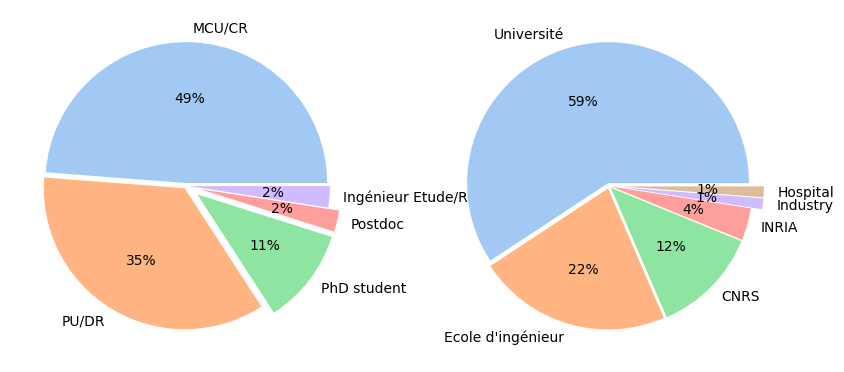

In [8]:
positions = questions_df.groupby(['position']).respondent.nunique().reset_index().sort_values(by=['respondent','position'],
                                                                                  ascending=False)
positions['percent']=100*positions.respondent/positions.respondent.sum()
print(positions)

employers = questions_df.groupby(['employer']).respondent.nunique().reset_index().sort_values(by=['respondent','employer'],
                                                                                  ascending=False)
employers['percent']=100*employers.respondent/employers.respondent.sum()

print(employers)

plt.subplots(figsize=(10,20))
plt.subplot(1,2,1)
_=plt.pie(positions.respondent,
        labels=positions.position,
        colors = sns.color_palette('pastel'),
        autopct = '%0.0f%%',
        explode = [0.02,0.02,0.1,0.1,0.02])

plt.subplot(1,2,2)
_=plt.pie(employers.respondent,
        labels=employers.employer,
        colors = sns.color_palette('pastel'),
        autopct = '%0.0f%%',
        explode = [0.02,0.02,0.02,0.02,0.1,0.1])




**Les réponses couvrent un bel éventail de laboratoires nationaux: 33 laboratoires (M=2.3 réponse par laboratoire), répartis relativement équitablement sur tout le territoire. 13 structures contribuent plus de 2 réponses, parmi lesquels on retrouve la plupart des grands laboratoires en automatique et sciences de l'ingénieur: L2S (Gif/Yvette: 12 réponses), FEMTO-ST (Besançon: 7 réponses), LAMIH (Valenciennes: 7 réponses), IMS (Talence: 6 réponses), GIPSA Lab (Grenoble: 5 réponses), LS2N (Nantes: 5 réponses), CRAN (Nancy: 3 réponses) et Ampère (Ecully: 3 réponses)**

In [9]:
print('%d laboratoires'%questions_df.affiliation.nunique())
print('%.1f réponse/labo'%questions_df.groupby(['affiliation']).respondent.nunique().reset_index().respondent.mean())

36 laboratoires
2.3 réponse/labo


In [12]:
questions_df.groupby(['affiliation']).respondent.nunique().sort_values(ascending=False).head(40)

affiliation
Laboratoire des signaux et systèmes (L2S, UMR 8506)                                                          12
Franche-Comté Électronique Mécanique Thermique et Optique - Sciences et Technologies (FEMTO-ST, UMR 6174)     7
Laboratoire d'Automatique de Mécanique et d'Informatique industrielles et Humaines (LAMIH, UMR 8201)          7
Laboratoire de l’Intégration du Matériau au Système (IMS, UMR 5218)                                           6
Laboratoire des Sciences du Numérique de Nantes (LS2N, UMR6004)                                               5
Laboratoire Grenoble Images Parole Signal Automatique (GIPSA-Lab, UMR5216)                                    5
Laboratoire d'Automatique, Systèmes Électriques et Environnement (LAS2E, Tunisie)                             3
Laboratoire Ampère (UMR 5005)                                                                                 3
Centre de Recherche en Automatique de Nancy (CRAN, UMR7039)                                 

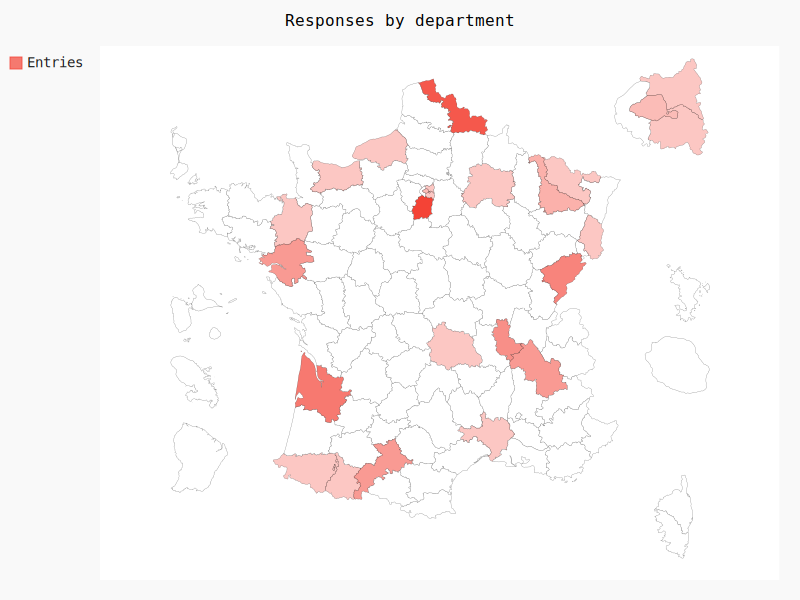

In [11]:
from pygal_maps_fr import maps
from IPython.display import SVG, display

dep = maps.Departments(human_readable=True)

dep.title = 'Responses by department'
dep.add('Entries', questions_df.groupby(['zip']).respondent.nunique().to_dict())
dep.render_to_file('map.svg')
display(SVG(dep.render(disable_xml_declaration=True)))


### Research activities

**Les domaines d'application de l'automatique reportés dans les réponses couvrent un vaste éventail de thématiques cliniques, dont en premier lieu les neurosciences (mentionnées par n=22/82 répondants, 27%), les sciences du mouvement et du contrôle moteur (n=19, 23\%), le diabète (n=14, 17\%), le cancer (n=14, 17\%), le système cardio-respiratoire (n=13, 16\%) et l'épidémiologie (n=13, 16\%).** 

**Outre ces domaines purement médicaux, la robotique chirurgicale est également mentionnée dans n=17 (20\%) des réponses, pour des activités qui incluent vraisemblablement une partie contrôle spécifique à ces dispositifs (ex. commande de robotique souple) mais aussi peut-être des activités de conception et instrumentation robotique qui pourraient s'avérer plus distantes des thématiques du GDR MACS et dont il serait être utile d'explorer l'interdisciplinarité avec d'autres GDR de la communauté (ex. GT Robotique et Santé du GDR Robotique)**

                    clinical_domains  respondent    percent
8                      Neurosciences          22  26.829268
7   Mouvement & Musculo-squelettique          19  23.170732
14    Robotique médicale & Chirurgie          17  20.731707
4                            Diabète          15  18.292683
2                             Cancer          14  17.073171
3                Cardio-respiratoire          13  15.853659
5      Epidémiologie & Infectiologie          13  15.853659
1                Biologie cellulaire           8   9.756098
11            Organisation des soins           6   7.317073
0                         Anesthésie           5   6.097561
10                     Ophtalmologie           5   6.097561
6                            Ethique           1   1.219512
9                                ORL           1   1.219512
12                  Pharmacaceutique           1   1.219512
13           Pédiatrie & Obstétrique           1   1.219512


<AxesSubplot:xlabel='count', ylabel='clinical_domains'>

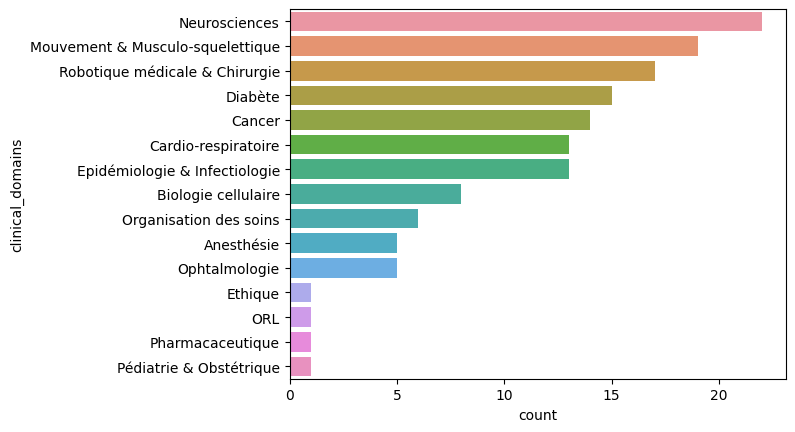

In [10]:
clinics = questions_df.groupby(['clinical_domains']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                          ascending=False)
clinics['percent']=100*clinics.respondent/questions_df.respondent.nunique()
print(clinics)


sns.countplot(y="clinical_domains", 
              order = questions_df.groupby(['clinical_domains']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).clinical_domains,
              
              data=questions_df.drop_duplicates(subset=['respondent','clinical_domains'], keep='first'))


**Ces activités recoupent de façon équitable la plupart des méthodologies de l'automatique, dont la modélisation (mentionné par n=59/82, 72\% des personnes), la commande (n=53, 65\%), les observateurs (n=34, 41\%), l'identification (n=30, 37\%) et l'analyse (n=27, 33\%).**

**Il est à noter que seulement 14 réponses (17\%) des réponses mentionnent des méthodologies dites "autres" - dont l'IA (n=7, 9\%), les capteurs (n=1) ou l'optimisation (n=3) - qui ne relèvent pas directement des activités du GDR, ce qui conforte notre diagnostic de l'existence d'une vraie communauté spécifiquement automaticienne se reconnaissant dans ces thématiques.**

                       control_domains  respondent    percent
9                         Modélisation          59  71.951220
7                             Commande          53  64.634146
10                        Observateurs          34  41.463415
8                       Identification          30  36.585366
0                              Analyse          27  32.926829
1   Autre (apprentissage machine / IA)           7   8.536585
5                 Autre (optimisation)           3   3.658537
2                     Autre (capteurs)           1   1.219512
3                   Autre (conception)           1   1.219512
4                  Autre (fabrication)           1   1.219512
6         Autre (traitement du signal)           1   1.219512


<AxesSubplot:xlabel='count', ylabel='control_domains'>

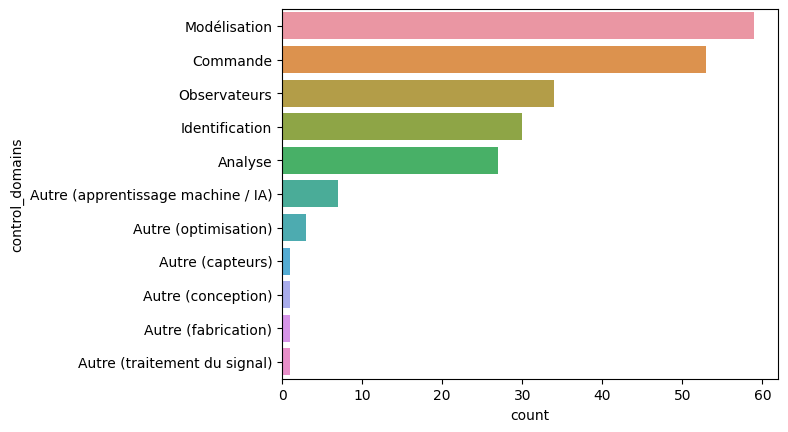

In [11]:
automs = questions_df.groupby(['control_domains']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                          ascending=False)
automs['percent']=100*automs.respondent/questions_df.respondent.nunique()
print(automs)

sns.countplot(y="control_domains", 
              order = questions_df.groupby(['control_domains']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).control_domains,
              
              data=questions_df.drop_duplicates(subset=['respondent','control_domains'], keep='first'))

### Publications

**Les questionnaires ont permis d'assembler une impressionnante bibliographie de 260 références, dont n=172 (66\%) articles de revues et 82 (31\%) communications de conférences, concernant plus de 540 co-auteurs (liste complète disponible en annexe). Celle-ci inclut à la fois des réferences dans des revues de la communauté automatique (n=186, 69\%), comme <i> IEEE Transactions on Automation Science and Engineering</i> (n=8), <i>IEEE Transactions on Automatic Control</i>(n=6), <i>International Journal of Robust and Nonlinear Control </i> (n=5) et <i>Automatica</i> (n=5), des revues de bio-ingénierie (<i>Biomedical Signal Processing and Control</i>: n=6, <i>IEEE Transactions on Biomedical Engineering</i>: n=3), mais aussi une grande variété de revues biologiques et médicales (n=73, 27\%; dont <i>PLOS Computational Biology</i>, <i>Journal of Theoretical Biology</i>, <i>Diabetes and Metabolism</i>, <i>European Journal of Obstetrics \& Gynecology</i>, <i>Journal of Neurophysiology</i> etc.) et un certain nombre de revues généralistes à fort impact (Nature Communications: n=2, PNAS: n=2, Scientific Reports: n=4)**

In [7]:
# types de publis 
pubs = biblio_df.groupby('type')[['journal','title']].nunique()
pubs['percent']=100*pubs.title/pubs.title.sum()
print(pubs)
print(pubs.title.sum())

                   journal  title    percent
type                                        
Autre                    2      2   0.769231
Chapitre de livre        2      2   0.769231
Conférence              52     82  31.538462
Journal                115    172  66.153846
Livre                    2      2   0.769231
260


In [8]:
# nb d'auteurs 
biblio_df.author.str.split(' and ').explode().nunique()

541

                        clinical_domains  title    percent
10                                 Neuro     61  23.461538
6                                Diabète     34  13.076923
12                Organisation des soins     27  10.384615
13        Robotique médicale & Chirurgie     25   9.615385
4                    Cardio-respiratoire     24   9.230769
7           Epiémiologie & Infectiologie     22   8.461538
9        Mouvement & Musculosquelettique     16   6.153846
1                                  Autre     15   5.769231
3                                 Cancer     14   5.384615
0                             Anesthésie     11   4.230769
2                    Biologie cellulaire      3   1.153846
5   Ce n'est pas de la bio ni du médical      2   0.769231
8                         Je ne sais pas      2   0.769231
11                           Obstétrique      1   0.384615


<AxesSubplot:xlabel='count', ylabel='clinical_domains'>

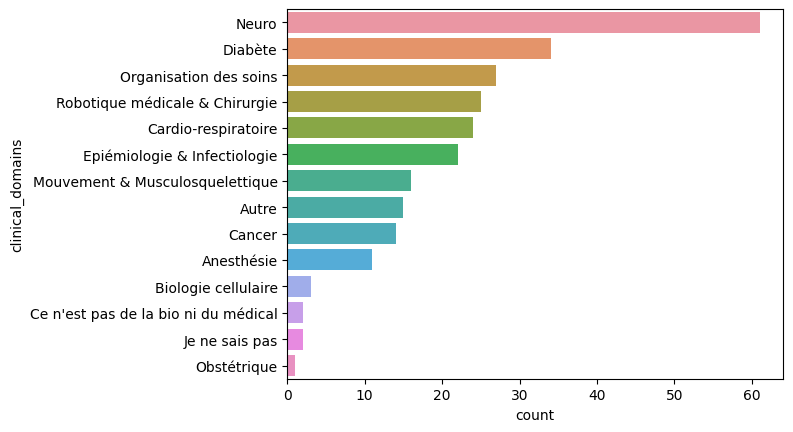

In [9]:
# répartition par domaines
clinics = biblio_df.groupby(['clinical_domains']).title.nunique().reset_index().sort_values(by='title',
                                                                                          ascending=False)
clinics['percent']=100*clinics.title/biblio_df.title.nunique()
print(clinics)


sns.countplot(y="clinical_domains", 
              order = biblio_df.groupby(['clinical_domains']).title.nunique().reset_index().sort_values(by='title',
                                                                                                     ascending=False).clinical_domains,
              
              data=biblio_df.drop_duplicates(subset=['title','clinical_domains'], keep='first'))

In [10]:
# types de revues 
types=biblio_df.groupby(['journal_type']).journal.count().reset_index()
types['percent']=100*types.journal/types.journal.sum()
print(types)

  journal_type  journal    percent
0      applied       73  27.238806
1      control      186  69.402985
2      general        9   3.358209


In [11]:
print('Revues les plus représentées:')
print('Control')
print(biblio_df[(biblio_df.type=='Journal')&
               (biblio_df.journal_type=='control')].groupby(['journal'],as_index=False).title.count().sort_values(by=['title'], ascending=[False]).head(10))
print('Applied')
print(biblio_df[(biblio_df.type=='Journal')&
               (biblio_df.journal_type=='applied')].groupby(['journal'],as_index=False).title.count().sort_values(by=['title'], ascending=[False]).head(10))

print('General')
print(biblio_df[(biblio_df.type=='Journal')&
               (biblio_df.journal_type=='general')].groupby(['journal'],as_index=False).title.count().sort_values(by=['title'], ascending=[False]).head(10))


print('\nConférences les plus représentées:')
print(biblio_df[biblio_df.type=='Conférence'].groupby(['journal'],as_index=False).title.count().sort_values(by=['title'], ascending=[False]).head(10))

Revues les plus représentées:
Control
                                              journal  title
20  IEEE Transactions on Automation Science and En...      8
19             IEEE Transactions on Automatic Control      6
36  International Journal of Robust and Nonlinear ...      5
5                                          Automatica      5
59                                            Sensors      5
1                           Annual Reviews in Control      4
23             IEEE/ASME Transactions on Mechatronics      3
21    IEEE Transactions on Control Systems Technology      3
10                       Control Engineering Practice      3
14           European Journal of Operational Research      3
Applied
                                        journal  title
6      Biomedical Signal Processing and Control      6
20  IEEE Transactions on Biomedical Engineering      3
23                          IET Systems Biology      2
3           Artificial Intelligence in Medicine      2
1       

In [12]:
for row in biblio_df[(biblio_df.type=='Journal')&
               (biblio_df.journal_type=='applied')].groupby(['clinical_domains']).journal.unique().reset_index().iterrows():
    print(row[1].clinical_domains+':')
    print('\t'+str(row[1].journal))

Autre:
	['Innovation and Research in Biomedical Engineering']
Cancer:
	['Biotechnology Progress' 'Journal of Theoretical Biology']
Cardio-respiratoire:
	['Biomedical Signal Processing and Control' 'Physiological Measurement'
 'Acta Biotheoretica' 'Artificial Intelligence in Medicine']
Diabète:
	['IET Systems Biology' 'IEEE Transactions on Biomedical Engineering'
 'Frontiers in Endocrinology'
 'IEEE/ACM Transactions on Computational Biology and Bioinformatics'
 'Journal of Diabetes Science and Technology' 'Diabetes and Metabolism']
Epiémiologie & Infectiologie:
	['IET Systems Biology' 'Biomedical Signal Processing and Control'
 'AIDS Research and Human Retroviruses' 'BioResearch Open Access'
 'Mathematical Biosciences and Engineering' 'Statistics in medicine'
 'Bulletin of mathematical biology' 'Biometrics'
 'IEEE Open Journal Of Engineering in Medicine and Biology'
 'Artificial Intelligence in Medicine' 'Journal of theoretical biology']
Mouvement & Musculosquelettique:
	['Biomedical Si

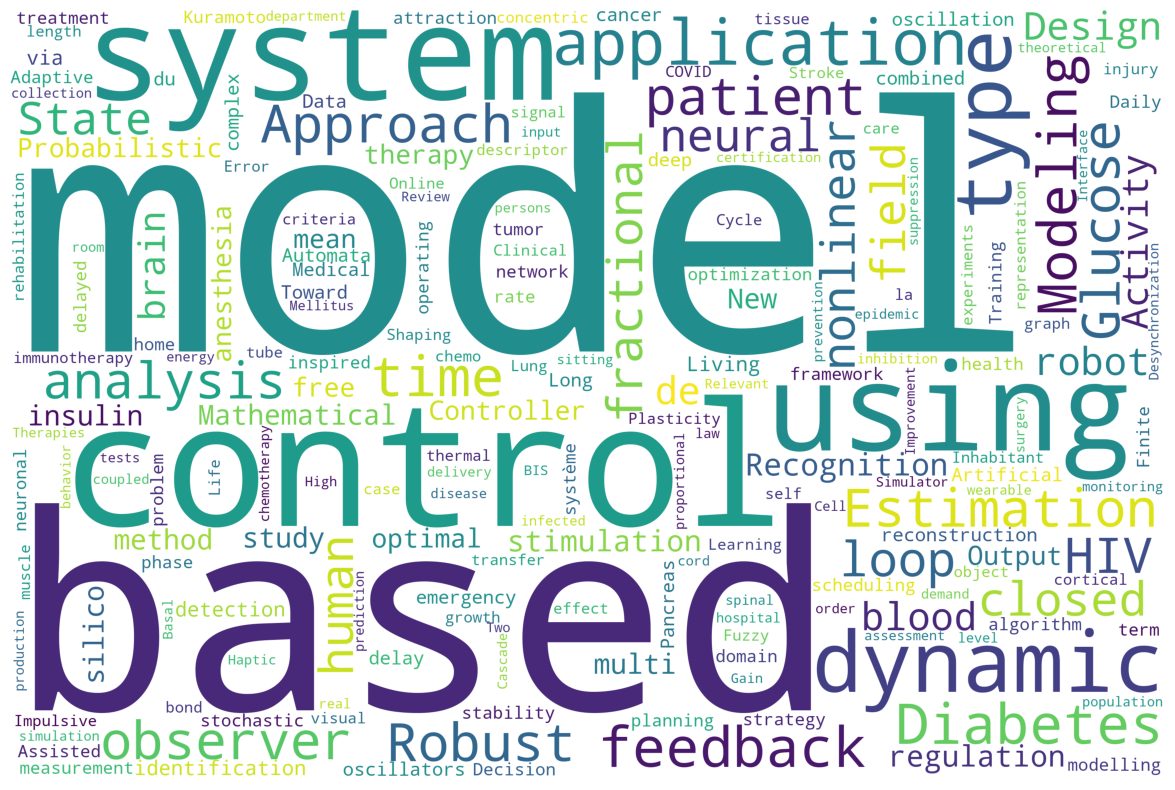

In [13]:
from wordcloud import WordCloud, STOPWORDS

# text from all titles
all_titles = ' '.join(biblio_df.title.tolist())

wordcloud = WordCloud(width= 3000, 
                      height = 2000, 
#                      random_state=1, 
                      background_color='white', 
#                      colormap='rainbow', 
                      collocations=False, 
                      stopwords = STOPWORDS).generate(all_titles)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud) 
plt.axis("off");


### Besoins

**Nos questionnaires exploraient les besoins des personnes sondées, à la fois en proposant directement un certain nombre d'actions (organisation d'une mailing list, de journées scientifiques, etc.) et, plus généralement, en recueillant quelles difficultés professionnelles que les répondant.e.s pouvaient rencontrer dans leur pratique de l'automatique appliquée à la santé. La majorité des personnes sondées seraient favorables, d'une part, à l'organisation de la communication interne (diffusion par email des actualités de l'action: n=72/82, 88\%; conception d'un site web dédié: n=71, 87\%) et, d'autre part, à des activités collectives de valorisation scientifique (organisation de journées scientifiques: n=68, 83\%; publication collective (livre bilan, special issue): n=65, 79\%).**

**Parmi les difficultés les plus souvent remontées, figurent en premier lieu la difficulté de collecter et accéder à des données médicales pour les recherches en automatique (n=13/82, 16\%) à cause de la difficultés des autorisations éthiques ou des contraintes de confidentialité, ainsi que la difficulté d'accès aux collaborateurs cliniques, que ce soit par manque de compréhension et d'une culture scientifique commune (n=9, 11\%), la difficulté à identifier les bons contacts prêts à collaborer (n=6, 7\%), ou le manque de temps qu'on ceux-ci à consacrer à la collaboration (n=5, 6\%). Le manque de financement spécifique à la recherche appliquée en santé est également mentionné (n=9, 11\%).** 

**Cet état des lieux montre une grande appétance pour l'application à la santé, mais qui est souvent frustrée par un "coût d'entrée" perçu dans le domaine principalement lié à un manque d'information (avec qui travailler et comment), que l'action 'Automatique et Santé' pourrait sans doute adresser, par exemple par des actions de mise en relation avec des cliniciens ou d'information sur les aspects administratifs liés à la recherche sur l'humain.** 

                           interests  respondent    percent
4                  informé par email          72  87.804878
7                     site web dédié          71  86.585366
5  participer journées scientifiques          68  82.926829
6      participer à des publications          65  79.268293
1       faciliter accès aux médecins           2   2.439024
0        faciliter accès aux données           1   1.219512
2    faciliter recrutement étudiants           1   1.219512
3                financements dédiés           1   1.219512


<AxesSubplot:xlabel='count', ylabel='interests'>

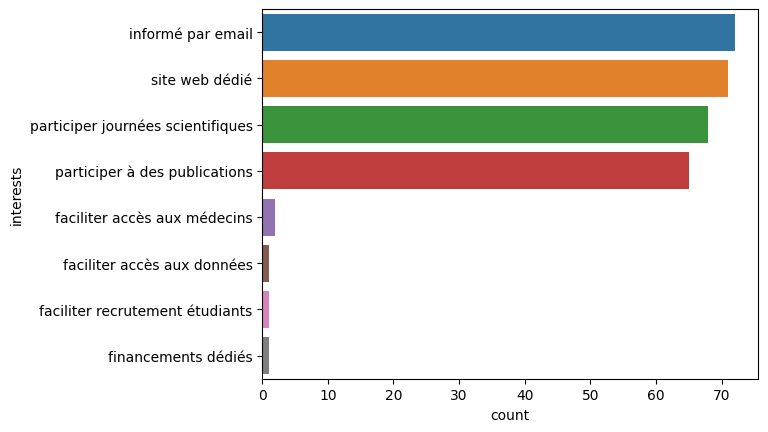

In [105]:
# count nb of unique last_name per interest 
# (removing duplicate entries for each last_name x interest, which correspond to distinct clinical domains and methods)
# and sort by decreasing count

interests = questions_df.groupby(['interests']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                          ascending=False)
interests['percent']=100*interests.respondent/questions_df.respondent.nunique()
print(interests)



sns.countplot(y="interests",
              order = questions_df.groupby(['interests']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).interests,
              data=questions_df.drop_duplicates(subset=['respondent','interests'], keep='first')) 

                                          pain_points  respondent    percent
5   difficulté pour collecter ou accéder à des don...          13  15.853659
4   difficulté pour accéder aux médecins (se compr...           9  10.975610
10                              manque de financement           9  10.975610
1   difficulté pour accéder aux médecins (identifi...           6   7.317073
2   difficulté pour accéder aux médecins (manque d...           5   6.097561
12        manque/difficulté valorisation industrielle           5   6.097561
3   difficulté pour accéder aux médecins (méfiance...           4   4.878049
0   complexité des problèmes/faible validité des r...           3   3.658537
7       difficulté pour publier (interdisciplinarité)           3   3.658537
11  manque de reconnaissance par les tutelles (int...           3   3.658537
8              lourdeur administrative (labo/hopital)           2   2.439024
13               petitesse de la communauté française           2   2.439024

<AxesSubplot:xlabel='count', ylabel='pain_points'>

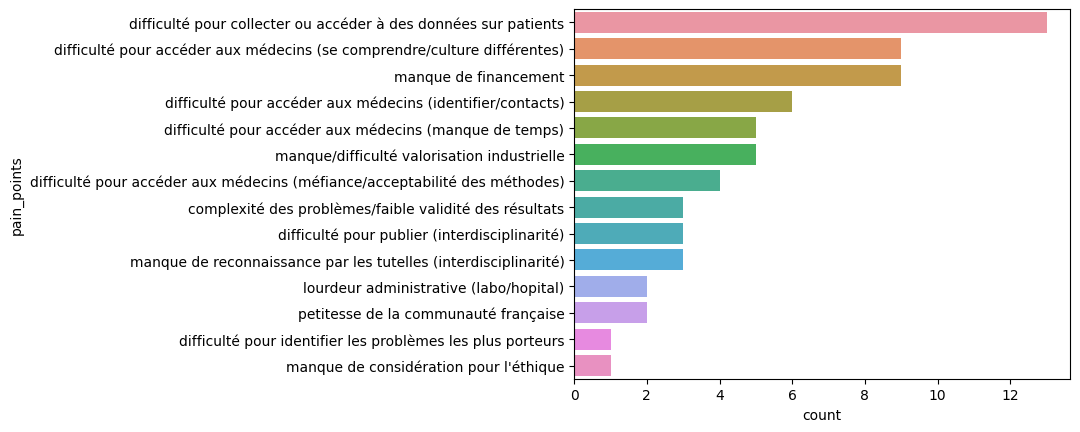

In [106]:
pains = questions_df.groupby(['pain_points']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                          ascending=False)
pains['percent']=100*pains.respondent/questions_df.respondent.nunique()
print(pains)


sns.countplot(y="pain_points",
              order = questions_df.groupby(['pain_points']).respondent.nunique().reset_index().sort_values(by='respondent',
                                                                                                     ascending=False).pain_points,
              data=questions_df.drop_duplicates(subset=['respondent','pain_points'], keep='first'))

## Bibtex

In [198]:
biblio_df = pd.read_csv('data/biblio.csv',index_col=0) 

In [199]:
from pybtex.database import parse_file, BibliographyData, Entry

# create unique entry per record

def parse_first_author(author_str): 
    # parse first author last name from a str like: Olivier Dupuis and Evelyne Decullier; M. Faillot and A. Chaillet; 
    # assumes it's the second token after a white space
    tokens = author_str.split(' ')
    return tokens[1]
    
def create_key(row): 
    # create key for each record, based on first 3 characters of author's last name and last 2 digits of year (ex. AUC22)
    first_author = parse_first_author(row['author'])
    year = str(row.year)
    key = first_author[0:3].upper() + year[-2:]
    return key 
    
# create key
biblio_df['key'] = biblio_df.apply(create_key, axis=1)
# update duplicates with cumcount
biblio_df.loc[biblio_df.key.duplicated(),'key'] = biblio_df.loc[biblio_df.key.duplicated(),'key'] + '_' + \
                                biblio_df[biblio_df.key.duplicated(False)].groupby(['key']).cumcount().astype(str)



In [200]:
# create bibtex entry

entries = {}

for index, row in biblio_df.iterrows(): 
    
    if row.type=='Journal':            
        entries[row.key] = Entry('article', [
                            ('author', str(row.author)),
                            ('title', str(row.title)),
                            ('journal', str(row.journal)),
                            ('volume', str(row.volume)),
                            ('number', str(row.number)),
                            ('pages', str(row.pages)),
                            ('year', str(row.year))])
    elif row.type=='Chapitre de livre':            
        entries[row.key] = Entry('incollection', [
                            ('author', str(row.author)),
                            ('title', str(row.title)),
                            ('booktitle', str(row.journal)),
                            ('year', str(row.year))])
    elif row.type=='Conférence':            
        entries[row.key] = Entry('inproceedings', [
                            ('author', str(row.author)),
                            ('title', str(row.title)),
                            ('booktitle', str(row.journal)),
                            ('year', str(row.year))])
    elif row.type=='Livre':            
        entries[row.key] = Entry('book', [
                            ('author', str(row.author)),
                            ('booktitle', str(row.title)),
                            ('publisher', str(row.journal)),
                            ('year', str(row.year))])
    else:            
        entries[row.key] = Entry('misc', [
                            ('author', str(row.author)),
                            ('title', str(row.title)),
                            ('howpublished', str(row.journal)),
                            ('year', str(row.year))])

        
bib_data = BibliographyData(entries) # warning: this has a side effect of entries

# save entry in df
#for key in entries: 
#    biblio_df.loc[biblio_df.key==key,'entry'] = entries[key].to_string('bibtex')
       
bib_data.to_file('biblio.bib','bibtex')

In [217]:
# assemble a tex file with bibliographic items

preamble = ('\\documentclass{article}\n'
            '\\usepackage{bibentry}\n'
            '\\nobibliography*\n'
            '\\title{Biblio Autom  \\& Santé}\n'
            '\\date{February 2023}\n'
            '\\begin{document}\n\maketitle\n')

end=('\\bibliographystyle{apalike}\n'
     '\\bibliography{biblio}\n'
     '\\end{document}\n')


with open('biblio.tex', 'w') as file:
    
    # preamble
    file.write(preamble)
    
    # list all clinical_domains as sections, and bibentries in alphabetical order
    
    for clinical_domain in biblio_df.groupby(['clinical_domains'], as_index=False).key.count().sort_values(by='key',ascending=False).clinical_domains.to_numpy(): 
        
        # write section tag
        file.write('\section{%s}\n'%clinical_domain.translate(str.maketrans({"&":  r"\&",
                                                                             "é" : r"\'e"})))
        
        # find all entries in that domain
        for key in biblio_df[biblio_df.clinical_domains == clinical_domain].sort_values(by='year').key: 
            file.write('\\noindent\\bibentry{%s}\\\\\\\\\n'%key)
        
    file.write(end)
    



In [216]:
biblio_df.to_csv('data/biblio.csv')